In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow


In [ ]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()



SLIC Superpixels

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 233MB/s]
Archive:  /content/Part1_SLIC.zip
replace /content/Part1_SLIC/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._groundTruth  
  inflating: /content/Part1_SLIC/sample_data/images/5096.jpg  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/images/._5096.jpg  
  inflating: /content/Part1_SLIC/sample_data/imag

In [ ]:


# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters):
    image = np.copy(img)
    cc=0
    for c in clusters:
        cc+=1
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[int(c.h), int(c.w)][0] = 0
        image[int(c.h), int(c.w)][1] = 0
        image[int(c.h), int(c.w)][2] = 0
        if  cc==2:
          break
    rgb_arr = color.lab2rgb(image) 
    rgb_arr = cv2.normalize(rgb_arr, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    rgb_arr = rgb_arr.astype(np.uint8)
    cv2_imshow(rgb_arr)
    return None


In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)
import time
def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    #image2 = copy.deepcopy(image)
    h=int(S/2);
    while h < img_h:
      w = int(S/2);
      while w < img_w:       
        clusters.append(make_SuperPixel(h, w, image))
        #image2 = cv2.circle(image2,(w,h),0,(255,255,255),-1)
        w = w + S; 
      h = h + S;
    return clusters

def relocate_cluster_center_at_lowgrad(clusters, image):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[x,y][1], img[x,y][2], x, y)
    # image2 = copy.deepcopy(image)
    for clus in clusters:
      H = clus.h
      W = clus.w
      c_gradient = np.sqrt((np.linalg.norm(image[H+1,W]-image[H-1,W]))**2+ (np.linalg.norm(image[H,W+1]-image[H,W-1]))**2)

      for j in range (-1,2):
        H = H + j
        for k in range(-1,2):
          W = W + k
         
          new_gradient = np.sqrt((np.linalg.norm(image[H+1,W]-image[H-1,W]))**2+ (np.linalg.norm(image[H,W+1]-image[H,W-1]))**2)
          if new_gradient <= c_gradient:
            clus.update(image[H,W][0],image[H,W][1],image[H,W][2],H,W)
            c_gradient = new_gradient
            #image2 = cv2.circle(image2,(W,H),0,(0,255,255),-1)
    return None
def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis,M):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
   
    for i in range(img_h):
      for j in range(img_w):
        #gen = [clus for clus in clusters if (abs(i - clus.h) <=2*S) and (abs(j - clus.w) <=2*S)]
        
        for clus in clusters:
          if ( abs(i - clus.h) <=2*S and abs(j - clus.w) <=2*S):
            
            dc = np.sqrt((clus.l - image[i,j][0])**2 + (clus.a - image[i,j][1])**2 + (clus.b - image[i,j][2])**2)
            ds = np.sqrt((clus.h - i)**2 + (clus.w - j)**2) 
  
            temp = np.sqrt(((dc/M)**2)+(ds/S)**2)
            
            if temp < dis[i,j]:
              dis[i,j] = temp
            
              cluster_tag.update({(i,j):clus})  
    for clus in clusters:
      for k,v in cluster_tag.items():
        if v == clus:
           clus.pixels.append(k)
    return None

def update_clusters(image,clusters):
    # image2 = copy.deepcopy(image)
    #### Write your code here ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    old_clusters = clusters
    for clus in clusters:
      if (len(clus.pixels)>0):
        new_h,new_w = np.mean(clus.pixels,axis = 0)
        clus.update(image[int(new_h),int(new_w)][0],image[int(new_h),int(new_w)][1],image[int(new_h),int(new_w)][2],int(new_h),int(new_w))
        #image2 = cv2.circle(image2,(int(new_w),int(new_h)),0,(0,0,255),-1)
    return None

def compute_res_error(old_clusters, new_clusters):
    #### Write your code here ####
    res_error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for i in range(len(old_clusters)):
      res_error = res_error + np.sqrt(((old_clusters[i].l - new_clusters[i].l)**2)+ ((old_clusters[i].a - new_clusters[i].a)**2)+((old_clusters[i].b - new_clusters[i].b)**2)+((old_clusters[i].h - new_clusters[i].h)**2)+((old_clusters[i].w - new_clusters[i].w)**2))
    res_error = res_error/len(old_clusters)    
    return res_error

def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M):
    
    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)
    
    # You can play around with these hyper-params.
    res_err = 5000 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 5 # tune this
    count = 0
    while(res_err >= threshold):
      x = time.time()

      assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis,M)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(image,clusters)
      res_err = compute_res_error(old_clusters, clusters)
      y=time.time()
      print("Time per iteration : ",y-x)
      if count ==0:
        count+=1
        print("ERROR AT INITIALIZATION : ",res_err)
      
    print("ERROR AT CONVERGENCE : ",res_err)
   
    return clusters    


In [ ]:
from scipy.io import loadmat
def boundary_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
    rgb_arr = color.lab2rgb(image) 
    return rgb_arr
    
def underseg_clusters(img, clusters,seg_region):
    supers=0
    
    for c in clusters:
      
      for p in c.pixels:
          
          if (p[0],p[1]) in seg_region:
             
              supers = supers + len(c.pixels)
              break
                   
    supers_reg = supers - 0.05*(supers)
    return supers_reg

def boundary_recall(g,image,clusters):
  final = boundary_clusters(image,clusters).astype(np.float64)
  final = cv2.normalize(final, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  final = final.astype(np.uint8)
  edge_fin = cv2.Canny(final,0,0)
  g1 = g[0,1][0,0][1]
  g1 = cv2.normalize(g1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  index_g1 = np.asarray(np.where(g1)).T
  index_edge_fin = np.asarray(np.where(edge_fin)).T
  match = 0
  for x in index_edge_fin:
      for y in index_g1:
        if (x[0] == y[0] and x[1] == y[1])or ( x[0]-1 == y[0] and x[1]-1 == y[1]) or (x[0]+1 == y[0] and x[1]+1 == y[1]) :
          match += 1
  fraction = match/(len(index_g1))
  print("BOUNDARY RECALL : ", fraction)
  return None

def underSeg_function(g,image,clusters,N):
  supr_pix_region=0
  g0 = g[0,1][0,0][0]
  g0 = cv2.normalize(g0, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  list_g0 = (g0 .reshape((1,g0.shape[0]*g0.shape[1]))).tolist()
  regions = list(set(list_g0[0]))
  for region in regions:
    seg_region = np.asarray(tuple(np.where(g0==region))).T  
    seg_region = [tuple(l) for l in seg_region]

    print("ONE REGION",region)
    supr_pix_region=underseg_clusters(image,clusters,seg_region)
    
    supr_pix_region += supr_pix_region
  u_s_err = (supr_pix_region - N)/N  
  print("UNDER SEGMENTATION ERROR : ",u_s_err,"\n")
  return None



In [ ]:
# Main Block:
import glob
import re
images = glob.glob("/content/Part1_SLIC/BSD_data/images/*.jpg")
for path in images:
    print(path +"\n")
    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    image = img_as_float(io.imread(path))
    # convert RGB to LAB
    image = color.rgb2lab(image)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width

    # k: Number of clusters/superpixels.
    k = 64 #can be 64 or 256 or 1024
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    # M can range between 1 to 40
    M = 40
    image_number = re.findall(r'\d+', path)
    
    gr_truth_mat = loadmat("/content/Part1_SLIC/BSD_data/groundTruth/test/" + image_number[1] +".mat")
    gr_truth = gr_truth_mat['groundTruth']   
    
    clusters = []
    cluster_tag ={} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    print("NUMBER OF CLUSTERS K :", k ,"\n")
    x = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    y=time.time()
    print("Total Run Time for K = 64 : ",y-x)
    
    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 
    
    k=256
    print("NUMBER OF CLUSTERS K :", k ,"\n")

    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    p = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    q=time.time()
    print("Total Run Time for K = 256 : ",q-p)


    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 

    k=1024
    print("NUMBER OF CLUSTERS K :", k ,"\n")

    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    X = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    Y=time.time()
    print("Total Run Time for K = 1024 : ",Y-X)

    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 

/content/Part1_SLIC/BSD_data/images/14092.jpg

NUMBER OF CLUSTERS K : 64 

Time per iteration :  20.930684566497803
ERROR AT INITIALIZATION :  10.691262090371138


In [ ]:
# Main Block:
import glob
import re
images = glob.glob("/content/Part1_SLIC/BSD_data/images/*.jpg")
for path in images:
    print(path +"\n")
    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    image = img_as_float(io.imread(path))
    # convert RGB to HSV
    image = color.rgb2hsv(image)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width

    # k: Number of clusters/superpixels.
    k = 64 #can be 64 or 256 or 1024
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    # M can range between 1 to 40
    M = 30
    image_number = re.findall(r'\d+', path)
    
    gr_truth_mat = loadmat("/content/Part1_SLIC/BSD_data/groundTruth/test/" + image_number[1] +".mat")
    gr_truth = gr_truth_mat['groundTruth']   
    
    clusters = []
    cluster_tag ={} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    print("NUMBER OF CLUSTERS K :", k ,"\n")
    x = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    y=time.time()
    print("Total Run Time for K = 64 : ",y-x)
    
    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 
    
    k=256
    print("NUMBER OF CLUSTERS K :", k ,"\n")
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    p = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    q=time.time()
    print("Total Run Time for K = 256 : ",q-p)


    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 

    k=1024
    print("NUMBER OF CLUSTERS K :", k ,"\n")
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel
    X = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)
    Y=time.time()
    print("Total Run Time for K = 1024 : ",Y-X)

    #boundary recall function 
    boundary_recall(gr_truth,image,clusters)
    #under segmentation error function
    underSeg_function(gr_truth,image,clusters,N) 

ANSWERS:

a) D = np.sqrt((dc/M)**2+(ds/S)**2) where dc is the distance btw color spaces l,a,b , ds is the distance btw the spatial coordinates, and M ranges from 1 to 40.

b) When M is 30, the result is compact whereas when M is 5, the result is has emphasis on the boundaries.

K=64, M= 30

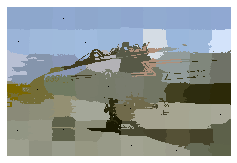

K=64, M=5

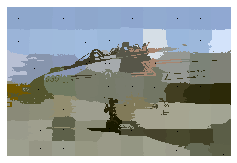

K=256,M = 40

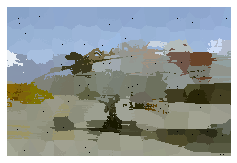

3) Time per iteration :  21.440876960754395

ERROR AT INITIALIZATION :  11.399520154983378

Time per iteration :  24.09263038635254

ERROR AT CONVERGENCE :  3.7778177492901217

Total Run Time for K = 64 :  45.549203395843506

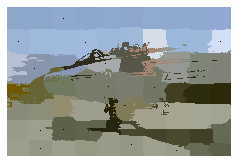

d) RUN TIME


K=64

Total Run Time for K = 64 :  43.00071382522583

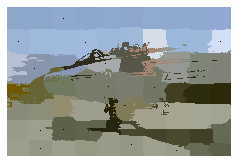

K=256

Total Run Time for K = 256 :  91.48558497428894

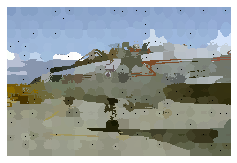

K=1024

Total Run Time for K = 1024 :  90.61981916427612

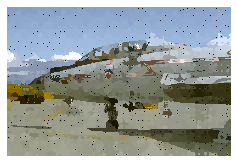

e)  Results of 10 images out of 50 (due to longer runtime for whole dataset)

